In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

### Setting Up Primitives and Functions for Demonstrating Convex Hull algorithms

Generating X and Y Coordinates

In [30]:
num_points = 15

rng = np.random.default_rng()

x = rng.integers(0, 50, size=num_points)
y = rng.integers(0, 50, size=num_points)

x,y

(array([ 3, 26, 23,  6, 28,  9, 28,  5, 43, 26,  6, 12, 27, 20, 31]),
 array([15, 21, 47, 31, 29,  1, 10,  2,  7, 25,  8, 10, 22, 11, 25]))

In [31]:
points = np.column_stack((x, y))
points = np.sort(points, axis=0)
points

array([[ 3,  1],
       [ 5,  2],
       [ 6,  7],
       [ 6,  8],
       [ 9, 10],
       [12, 10],
       [20, 11],
       [23, 15],
       [26, 21],
       [26, 22],
       [27, 25],
       [28, 25],
       [28, 29],
       [31, 31],
       [43, 47]])

<Axes: >

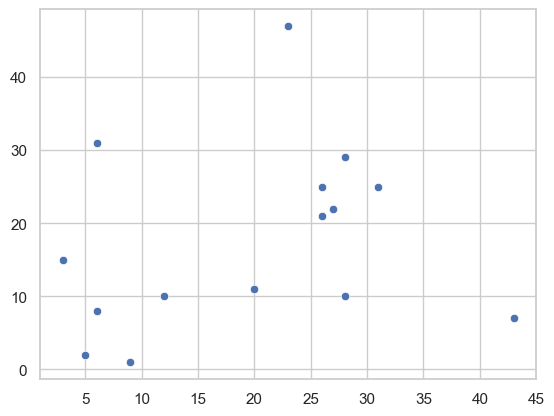

In [32]:
sns.scatterplot(x=x, y=y)

Defining a get_orientation function

In [33]:
def get_orientation(p1, p2, p3):
    cross = np.cross(p2 - p1, p3 - p1)

    if np.isclose(cross, 0):
        return (0, 'collinear')      # Collinear
    return (1, 'ccw') if cross > 0 else (2, 'cw')

In [34]:
points[0][0], points[0][1]

(np.int64(3), np.int64(1))

Demonstration of functioning get_orientation method

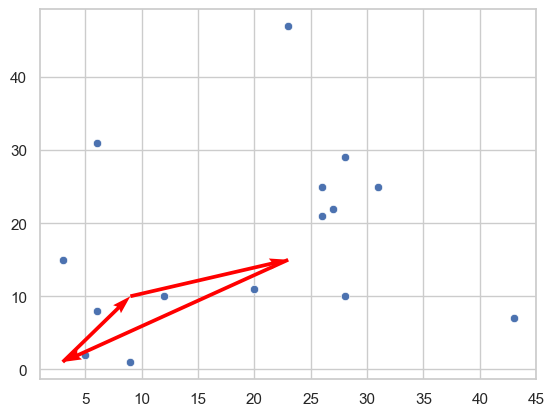

In [35]:
sns.scatterplot(x=x, y=y)

hull_points = [0,4,7]
x = points[hull_points, 0]
y = points[hull_points, 1]

# Calculate vectors (u, v) pointing to the next point
# np.roll shifts the array so we subtract point[i] from point[i+1]
u = np.roll(x, -1) - x
v = np.roll(y, -1) - y

# angles='xy', scale_units='xy', and scale=1 make the arrows 
# exactly as long as the distance between points
plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)

In [36]:
val = get_orientation(points[0], points[4], points[7])
val[1]

C:\Users\bisho\AppData\Local\Temp\ipykernel_12468\2027307422.py:2: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


'cw'

# Algorithm 1: Slow, Naive

In [37]:
hull_vectors = []

available_points = points.copy()

for i, p in enumerate(available_points):

    for j, q in enumerate(available_points):
        
        if i == j:
            continue

        valid = True

        for k, r in enumerate(available_points):
            
            if k == i or k == j:
                continue
            
            if get_orientation(p, q, r)[1] == 'ccw':
                valid = False
                break
    
            
        if valid:
            print(f"Appending p: {p}, q: {q}")
            hull_vectors.append([p, q])
            

hull_vectors = np.array(hull_vectors)

Appending p: [3 1], q: [6 8]
Appending p: [5 2], q: [3 1]
Appending p: [6 8], q: [43 47]
Appending p: [20 11], q: [5 2]
Appending p: [23 15], q: [20 11]
Appending p: [43 47], q: [23 15]


C:\Users\bisho\AppData\Local\Temp\ipykernel_12468\2027307422.py:2: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


In [38]:
hull_points = np.unique(hull_vectors.reshape(len(hull_vectors) *2,2), axis = 0)
hull_points

array([[ 3,  1],
       [ 5,  2],
       [ 6,  8],
       [20, 11],
       [23, 15],
       [43, 47]])

<Axes: >

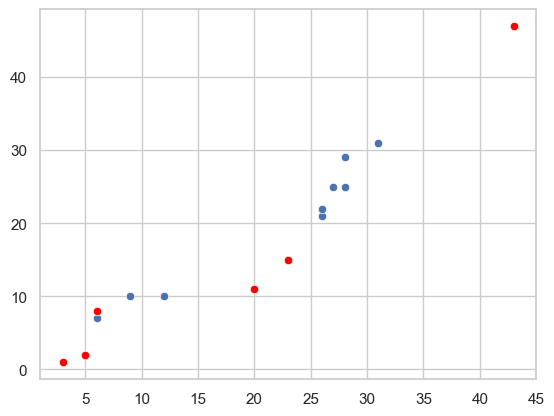

In [39]:
sns.scatterplot(x = points[:, 0], y = points[:,1])
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')


<Axes: >

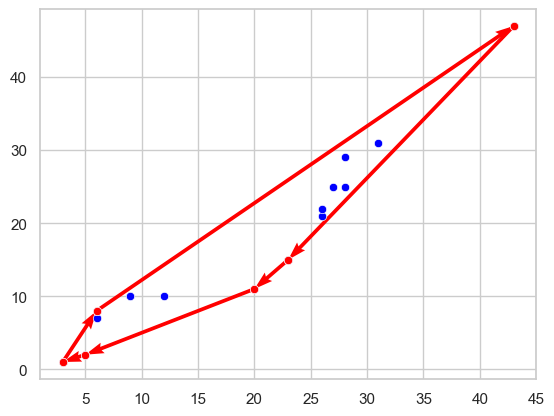

In [40]:
sns.scatterplot(x=x, y=y)

starts = hull_vectors[:, 0]
ends   = hull_vectors[:, 1]

x = starts[:, 0]
y = starts[:, 1]
u = ends[:, 0] - x
v = ends[:, 1] - y

plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
sns.scatterplot(x = points[:, 0], y = points[:,1], color = 'blue')
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')

# Algorithm 2: 